# Machine Learning with Python - Dimensionality Reduction

Machine learning applications often involve high-dimensional data. Consider a $1000 \times 1000$ pixel image. If we stack the intensities of pixels into a vector, we obtain a vector of length $10^6$. In this round, we study dimensionality reduction methods that transform long feature vectors to shorter feature vectors which retain most of the relevant information contained in the raw long vectors. Such dimensionality reduction is useful for at least three reasons: 

- Shorter feature vectors typically imply less computation. 
- Shorter (but informative) feature vectors ensure good generalization of ML methods from training data to new data points. Using very long feature vectors bears the risk of overfitting the training data. 
- Transforming long data point vectors to vectors of length 2 (or 3) allows to visualize data points in a scatter plot.

One of the most popular methods for dimensionality reduction is **principal component analysis** (PCA). The aim of PCA is to learn a linear transformation (matrix) $\mathbf{W}$ which maps the (long) feature vector $\mathbf{z}$ to a new (short) feature vector $\mathbf{x} = \mathbf{W} (\mathbf{z} - \overline{\mathbf{z}})$ ($\overline{\mathbf{z}}$ is the sample mean). The aim of PCA is to choose the matrix $\mathbf{W}$ such that it is possible to reconstruct $\mathbf{z}$ from $\mathbf{x}$ with minimum reconstruction error. 

PCA exploits the variance-covariance structure of the data, and creates the new features based on the dependencies present in the data. For example, recall that we added random features into our data during the previous rounds. By measuring the variances and covariances in the features, PCA should be able to recognize that there are no significant dependecies created by the random data (especially when sample size is large). Thus, it will create the principal components in such way that the most important ones do not contain information about the random data.

## Learning goals

After this round, you should 

- understand the basic idea behind dimensionality reduction. 
- be able to implement PCA using Python libraries. 
- understand the trade-off between amount of dimensionality reduction and information loss. 
- be able to combine PCA with a supervised ML method such as linear regression. 

## Relevant Sections in [Course Book](https://arxiv.org/abs/1805.05052)

Chapter 9 of the [Course Book](https://arxiv.org/abs/1805.05052)  - Dimensionality Reduction.


## Additional Material  

* [Video lecture](https://www.youtube.com/watch?v=Zbr5hyJNGCs) of Prof. Andrew Ng on dimensionality reduction 
* [Video lecture](https://www.youtube.com/watch?v=cnCzY5M3txk) of Prof. Andrew Ng on dim. red. for data visualization 
* [Video lecture](https://www.youtube.com/watch?v=T-B8muDvzu0) of Prof. Andrew Ng on principal component analysis
* https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues

## Bananas and Apples

<a id="data"></a>
Consider a dataset containing $m=30$ images of apples and bananas: 

* 15 images of apples stored in the files named `1.jpg` to `15.jpg`
* 15 images of bananas stored in the files named `16.jpg` to `30.jpg`

The files contain color images, but for our purposes we convert them to grayscale images. We can represent each pixel of a grayscale image by a number between 0 (black) and 255 (white). The size of the images is $50\times50$ pixels. Thus, we can represent each fruit image by the "raw" data vector $\mathbf{z} =\big(z_{1},\ldots,z_{J}\big)^{T} \in \mathbb{R}^{2500}$ whose $j$th entry $z_{j}$ is the grayscale level of the $j$th pixel. 

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Demo.</b> Loading the Data. 
   
    
The following code block loads the images, converts them into grayscale images and stores them in the matrix $\mathbf{Z} \in \mathbb{R}^{30 \times 2500}$ whose $i$th row $\mathbf{z}^{(i)} \in \mathbb{R}^{2500}$ contains the grayscale intensities for the $i$th image. The first three apple images and the first three banana images are displayed.

 </div>

In [46]:
# Import required libraries (packages) for this exercise
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

The shape of the datamatrix Z is (30, 2500)


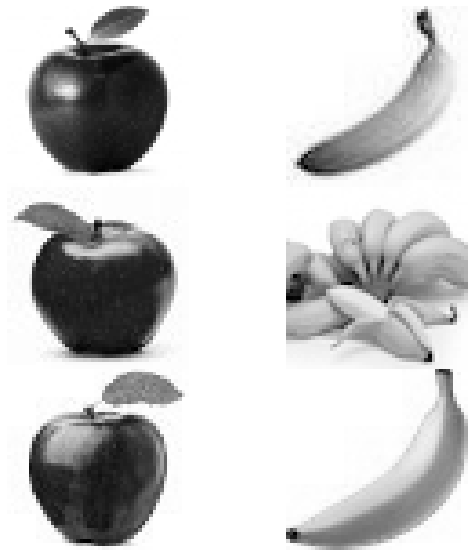

In [55]:
m = 30 # Number of images to include in dataset
dataset = np.zeros((m,50,50), dtype=np.uint8)   # create numpy array for images and fill with zeros 
D = 50*50  # length of raw feature vectors 

for i in range(1, m+1):
    # With convert('L') we convert the images to grayscale
    try:
        img = Image.open('/coursedata/fruits/%s.jpg'%(str(i))).convert('L') # Read in image from jpg file
    except:
        img = Image.open('../../data/fruits/%s.jpg'%(str(i))).convert('L') # Read if you are doing exercise locally
    dataset[i-1] = np.array(img,dtype=np.uint8)             # Convert image to numpy array with greyscale values
    
# Store raw image data in matrix Z
Z = dataset.reshape(m,-1)  # Reshape the 50 x 50 pixels into a long numpy array of shape (2500,1)
print("The shape of the datamatrix Z is", Z.shape) 

# Display first three apple images (fruits1.jpg,fruits2.jpg,fruits3.jpg) 
# and first three banana images (fruits16.jpg,fruits17.jpg,fruits18.jpg)
fig, ax = plt.subplots(3, 2, figsize=(10,10), gridspec_kw = {'wspace':0, 'hspace':0})
for i in range(3):
    for j in range(2):
        ax[i,j].imshow(dataset[i + (15*j)], cmap='gray')
        ax[i,j].axis('off')
plt.show()

## Principal Component Analysis
<a id="Q1"></a>

Each fruit image is represented by the raw data vector  $\mathbf{z}^{(i)} \in \mathbb{R}^{D}$, which contains the grayscale values for each of the $D=50^{2}=2500$ pixels. Let $\mathbf{Z}_c$ denote the column-wise centralized data matrix

\begin{equation}
\mathbf{Z}_c = \left(\textbf{z}_c^{(1)}, \ldots, \textbf{z}_c^{(m)} \right)^T =  \left( \textbf{z}^{(1)} - \overline{\textbf{z}}, \ldots, \textbf{z}^{(m)} - \overline{\textbf{z}}\right)^T,
\end{equation}

that is obtained by subtracting the empirical mean vector $\overline{\textbf{z}}$ from each row (data point) in $\textbf{Z}$.

The aim of PCA is to find an optimal compression matrix $\mathbf{W} \in \mathbb{R}^{n \times D}$, with $n \ll D$, that transforms the (long) data vector $\mathbf{z}_c^{(i)} \in \mathbb{R}^{D}$ to a short feature vector $\mathbf{x}^{(i)} \in \mathbb{R}^{n}$ via

<a id="eq1"></a>
\begin{equation}
    \mathbf{x}^{(i)}=\mathbf{W} \mathbf{z}_c^{(i)}. 
    \tag{1} 
    \label{eq:1}
\end{equation}

We can quantify the loss of information incurred by replacing $\mathbf{z}_c^{(i)}$ with $\mathbf{x}^{(i)}$ by the smallest possible reconstruction error achieved by a linear reconstruction method $\widehat{\mathbf{z}}_c^{(i)} = \mathbf{R} x^{(i)}$ with some matrix $\mathbf{R} \in \mathbb{R}^{D \times n}$. The minimal reconstruction error is given by: 

<a id="eq2"></a>
\begin{align}
 \mathcal{E}(\mathbf{W}) & = \min_{\mathbf{R} \in \mathbb{R}^{D \times n}} (1/m) \sum_{i=1}^{m} \| \mathbf{z}_c^{(i)} - \mathbf{R} \mathbf{x}^{(i)} \|^{2}  \nonumber \\ 
 & \stackrel{\eqref{eq:1}}{=} \min_{\mathbf{R} \in \mathbb{R}^{D \times n}} (1/m) \sum_{i=1}^{m} \| \mathbf{z}_c^{(i)} - \mathbf{R} \mathbf{W} \mathbf{z}^{(i)}\|^{2}.
 \label{eq:2}
 \tag{2}
\end{align} 

Equivalently, the minimal reconstruction error can be written using the raw (uncentered) data $\mathbf{Z}$ as

\begin{equation}
\mathcal{E}(\mathbf{W}) = \min_{\mathbf{R} \in \mathbb{R}^{D \times n}} (1/m) \sum_{i=1}^{m} \| \mathbf{z}_c^{(i)} + \overline{\mathbf{z}} - \overline{\mathbf{z}} - \mathbf{R} \mathbf{W} \mathbf{z}_c^{(i)} \|^{2} = \min_{\mathbf{R} \in \mathbb{R}^{D \times n}} (1/m) \sum_{i=1}^{m} \| \mathbf{z}^{(i)} - \big(\mathbf{R} \mathbf{W} \mathbf{z}_c^{(i)} + \overline{\mathbf{z}}\big) \|^{2}.
\tag{3}
\label{eq:3}
\end{equation}

Note that the optimal reconstruction matrix $\mathbf{R}$ (which achieves the minimum in \eqref{eq:2}) depends on the given compression matrix $\mathbf{W}$. However, we are not interested in the optimal reconstruction matrix itself but only in the associated minimum reconstruction error $\mathcal{E}(\mathbf{W})$.

To find the compression matrix $\mathbf{W}$ which minimizes the reconstruction error $\mathcal{E}(\mathbf{W})$, we use the **eigenvalue decomposition** of the sample covariance matrix

<a id="eq3"></a>
\begin{equation}
\mathbf{Q} =(1/m) \mathbf{Z}_c^{T} \mathbf{Z}_c,
\label{eq:4}
\tag{4}
\end{equation}

where $\mathbf{Z}_c=\big(\mathbf{z}_c^{(1)},\ldots,\mathbf{z}_c^{(m)} \big)^{T} \in \mathbb{R}^{m \times D}$ is the column-wise centered data matrix. Note that $\mathbf{Q}$ is also by definition the covariance matrix of the raw data $\mathbf{Z}$.

Since the sample covariance matrix $\mathbf{Q}$ is [positive semi-definite](https://en.wikipedia.org/wiki/Definiteness_of_a_matrix), it has an eigenvalue decomposition of the form 

\begin{equation}
\mathbf{Q} = \big( \mathbf{u}^{(1)},\ldots,\mathbf{u}^{(D)}\big) {\rm diag} \{\lambda^{(1)},\ldots,\lambda^{(D)} \} 
 \big( \mathbf{u}^{(1)},\ldots,\mathbf{u}^{(D)}\big)^{T}.
\end{equation} 

Here, the orthonormal vectors $\mathbf{u}^{(r)}$ are eigenvectors of $\mathbf{Q}$ which correspond to the decreasingly ordered eigenvalues $\lambda^{(1)} \geq \lambda^{(2)} \geq \ldots \geq \lambda^{(D)}$ of $\mathbf{Q}$. 

It can be shown that the reconstruction error \eqref{eq:2} is minimal for the compression matrix 

<a id="eq4"></a>
\begin{equation}
\label{eq:5}
\tag{5}
\mathbf{W}_{\rm PCA} = \big( \mathbf{u}^{(1)},\ldots,\mathbf{u}^{(n)} \big)^{T},\in \mathbb{R}^{n \times D}, 
\end{equation}

i.e., $\mathcal{E}(\mathbf{W}_{\rm PCA}) = \min_{\mathbf{W} \in \mathbb{R}^{n \times D}} \mathcal{E}(\mathbf{W})$. 

Note that the rows of $\mathbf{W}_{\rm PCA}$ are the eigenvectors $\mathbf{u}^{(1)},\ldots,\mathbf{u}^{(n)}$ of $\mathbf{Q}$ corresponding to the $n$ largest eigenvalues $\lambda^{(1)},\ldots,\lambda^{(n)}$ of $\mathbf{Q}$. Moreover, the minimum reconstruction error $\mathcal{E}(\mathbf{W}_{\rm PCA})$ is achieved 
for the reconstruction matrix $\mathbf{R} = \mathbf{W}_{\rm PCA}^{T}$ and given in terms of the eigenvalues of $\mathbf{Q}$ as  

<a id="eq5"></a>
\begin{equation}
\label{eq:6}
\tag{6}
\mathcal{E}(\mathbf{W}_{\rm PCA}) = \sum_{r = n+1}^{D} \lambda^{(r)}. 
\end{equation} 

When using the optimal compression matrix $\mathbf{W}_{\rm PCA}$, the entries of the transformed feature vector $\mathbf{x} = \mathbf{W}_{\rm PCA} \mathbf{z}_c$ are referred to as **principal components**. The first entry $x_{1}$ is the first principal component (PC), the second entry $x_{2}$ is the second PC and so on. 

## PCA in scikit-learn

The PCA implementation in scikit-learn is based on calculating the SVD (singular value decomposition) of the centered data matrix $\mathbf{Z}$. While this approach differs from the one presented in this notebook in its technical implementation, it is mathematically equivalent and yields the same compression matrix $\mathbf{W}_{\rm PCA}$. In the student tasks in this notebook we will use the `PCA` class from scikit-learn to find the compression matrix $\mathbf{W}_{\rm PCA}$, and to calculate the PCA compressed data $\mathbf{X}$, as well as the reconstructed data and reconstruction error. Below is a short description of the most important functions of the `PCA` class:

- `PCA.fit(Z)` calculates $\mathbf{W}_{PCA}$ and stores it in the attribute `PCA.components_`. Note that the data matrix `Z` should be uncentered, since the `PCA` class stores the sample mean of the data that is used when transforming and   reconstructing data with the fitted `PCA` object.

- `PCA.transform(Z)` performs PCA transformation on `Z` in order to get the lower dimensional representation `X` of the data. Observe that the function performs the centralization of `Z` "under the hood", and as such the resulting compression is of the form $\mathbf{X} = \mathbf{Z}_c\mathbf{W}^T$.

- `PCA.inverse_transform(X)` performs the inverse operation to `PCA.transform(Z)`, that is, it takes as input the PCA transformed data `X` and returns a reconstrution `Z_hat` with the same dimensionality as the original data `Z`. Mathematically, the reconstruction is of the form $\hat{\mathbf{Z}} = \mathbf{XW} + \overline{\mathbf{Z}}$, where each row of $\overline{\mathbf{Z}}$ is the sample mean.

<a id='demoPCA'></a>
<div class=" alert alert-info">
    <b>Demo.</b> PCA with one component. <br/>

The code snippet below uses PCA to transform two-dimensional gaussian data to one dimension. 
    
Notice how the PCA transform projects the data onto the subspace (in this case the line) spanned by the first principal component, i.e. the direction that explains the maximal amount of variance in the data.
</div>

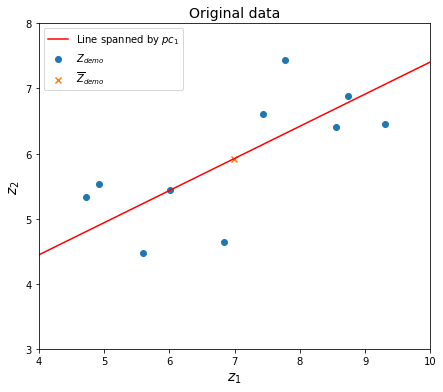

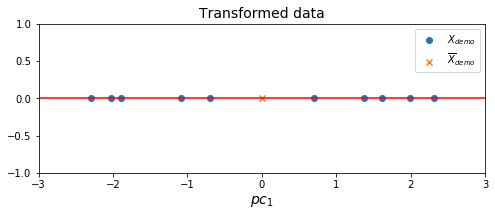

In [56]:
from numpy.random import multivariate_normal
from sklearn.decomposition import PCA

# Create synthetic dataset of multiavariate normal data
np.random.seed(1)
mean = [8, 7]
cov=[[4, 1], [1, 1]]
Z_demo = np.random.multivariate_normal(mean, cov, 10)

# Apply PCA on the demo dataset with n=2 components
pca = PCA(n_components=1)    # Define pca object with n=1 components
pca.fit(Z_demo)    # Fit pca object on data
X_demo = pca.transform(Z_demo)    # Perform pca transform on data

# Get components and singular values
W = pca.components_

# Plot the original data
plt.figure(figsize=(8,6))
plt.axes(aspect='equal')
plt.scatter(Z_demo[:,0], Z_demo[:,1])
plt.scatter(pca.mean_[0], pca.mean_[1], marker='x')
plt.plot([pca.mean_[0] - 10*W[0,0], pca.mean_[0] +  10*W[0,0]], [pca.mean_[1] - 10*W[0,1], pca.mean_[1] + 10*W[0,1]], color='red')
plt.xlim(4, 10)
plt.ylim(3, 8)
plt.xlabel("$z_1$", fontsize=14)
plt.ylabel("$z_2$", fontsize=14)
plt.title("Original data", fontsize=14)
plt.legend(["Line spanned by $pc_1$","$Z_{demo}$", "$\overline{Z}_{demo}$"])
plt.show()

# Plot the transformed data
plt.figure(figsize=(8,6))
plt.axes(aspect='equal')
plt.scatter(X_demo, np.zeros(10), label="$X_{demo}$")
plt.scatter(0,0, marker='x', label="$\overline{X}_{demo}$")
plt.plot([-3, 3], [0, 0], color='red')
plt.xlim(-3, 3)
plt.ylim(-1, 1)
plt.xlabel("$pc_1$", fontsize=14)
plt.title("Transformed data", fontsize=14)
plt.legend()
plt.show()

The same principle that is shown in the demo above also applies to higher dimensions. When performing PCA with $n$ components, the data is projected onto the $n$-dimensional subspace spanned by those $n$ components that maximize the explained variance.

Next, you will get to perform PCA yourself on the data containing fruit images.

<a id='ImplementPCA'></a>
<div class=" alert alert-warning">
    <b>Student Task.</b> Compute PCA. <br/>

Apply PCA to the data matrix $\mathbf{Z}$ obtained from the fruit images. In particular, compute the optimal compression matrix `W_pca` for the specified number $n$ of PCs (the value of n is set in the code snippet below). 
The compression matrix should be stored in the numpy array `W_pca` of shape (n,2500). Also, compute the corresponding reconstruction error
\begin{equation}
(1/m) \sum_{i=1}^{m} \big\| \mathbf{z}^{(i)} - \mathbf{W}_{\rm PCA}^{T} \mathbf{x}^{(i)} \big\|^{2}_{2} =  
(1/m) \sum_{i=1}^{m} \big\| \mathbf{z}^{(i)} - \mathbf{W}_{\rm PCA}^{T} \mathbf{W}_{\rm PCA} \mathbf{z}^{(i)} \big\|^{2}_{2} 
\end{equation} 

You should store the reconstruction error in variable `err_pca`. 
    
Hints: 
- use the Python class `PCA` from the library `sklearn.decomposition` to compute the optimal compression matrix $\mathbf{W}_{\rm pca}$ for the feature vectors (representing fruit images) in the rows of `Z`.
- use the functions described above to calculate the reconstruction `Z_hat`.
- then, the resulting `Z_hat` to calculate the reconstruction error according to the formula above
- documentation: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
 

</div>

In [57]:
from sklearn.decomposition import PCA

n = 10  # Define number of principal components
pca = PCA(n_components=n)    
pca.fit(Z)    # Fit pca object on data
W_pca = pca.components_
X = pca.transform(Z)    # Perform pca transform on data
Z_hat = pca.inverse_transform(X)

err_pca = (1/m)*((Z-Z_hat)*(Z-Z_hat)).sum()

# YOUR CODE HERE
# raise NotImplementedError()

print(f'Shape of Z: {Z.shape}')
print(f'Shape of compression matrix W: {W_pca.shape}')
print(f'PCA error: {err_pca}')

Shape of Z: (30, 2500)
Shape of compression matrix W: (10, 2500)
PCA error: 925711.7606314785


In [58]:
# Perform sanity checks on the results
assert W_pca.shape == (n, Z.shape[1]), "Output matrix (W_pca) dimensions are wrong."
assert err_pca <= 1e6, "The reconstruction error is too high."

print('Sanity checks passed!')


Sanity checks passed!


## Trading Compression Against Information Loss
<a id="Q2"></a>

We now study the effect of using different numbers $n$ of PCs for the new feature vector $\mathbf{x}$. In particular, we will observe a trade-off between amount of compression (which requires small $n$) and small loss of information and reconstruction error (which requires large $n$).

<a id='reconstructionerror'></a>
<div class=" alert alert-warning">
    <p><b>Student Task.</b> Reconstruction Error vs. Number of PC. <br/> </p>
    
Use the fruit image data `Z` and analyze how the reconstruction error of PCA changes with the number of PCs n used. In particular, apply PCA to the dataset `Z` for varying number of PCs $n=1,\ldots,m$. For each choice for $n$, compute the corresponding reconstruction error (see ([5](#eq5))) and store it in the numpy array `err_pca` of shape (m, ).

Hints:
    
- Loop for $n = 1,2,...,m$ components.
- For each value of $n$, compute the feature vectors $\mathbf{x}^{(i)} = \mathbf{W}_{\rm PCA} \mathbf{z}^{(i)}$ for $i=1,\ldots,m$.
- Compute the optimal reconstruction $\widehat{\mathbf{z}}^{(i)} = \mathbf{W}_{\rm PCA}^{T} \mathbf{x}^{(i)}$.
- Compute the reconstruction error $(1/m) \sum_{i=1}^{m} \big\| \mathbf{z}^{(i)} - \widehat{\mathbf{z}}^{(i)}\big\|^{2}_{2}$.
- Store the reconstruction errors in the numpy array `err_pca`. The first entry should be the reonstruction error obtained for $n=1$.
</li>

</div>

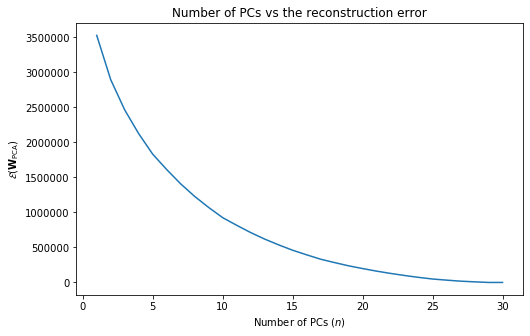

In [59]:
err_pca = np.zeros(m)  # Array for storing the PCA errors

for i in range(m):
    
    n=i+1
    pca = PCA(n_components=n)    
    pca.fit(Z)    # Fit pca object on data
    W_pca = pca.components_
    X = pca.transform(Z)    # Perform pca transform on data
    Z_hat = pca.inverse_transform(X)


    err_pca[i] = (1/m)*((Z-Z_hat)*(Z-Z_hat)).sum()
    
    ### STUDENT TASK ### 
    # Compute the reconstruction error for PCA using n PCs and store it in err_pca[n-1]
    # YOUR CODE HERE
    # raise NotImplementedError()
    
# Plot the number of PCs vs the reconstruction error
plt.figure(figsize=(8,5))
plt.plot([i + 1 for i in range(m)], err_pca)
plt.xlabel('Number of PCs ($n$)')
plt.ylabel(r'$\mathcal{E}(\mathbf{W}_{\rm PCA})$')
plt.title('Number of PCs vs the reconstruction error')
plt.show()  


In [60]:
# Perform some sanity checks on the outputs
assert err_pca.shape == (m, ), "shape of err_pca is wrong."
assert err_pca[0] > err_pca[m-1], "values of err_pca are incorrect"
assert err_pca[0] > err_pca[1], "values of err_pca are incorrect"

print('Sanity checks passed!')


Sanity checks passed!


If the task is solved correctly, we can see that the reconstruction error decreases quite smoothly with an increasing number of components. Next, we will see how the decreasing reconstruction error translates to practice in the case of images.

In the demo below, we will plot reconstructed images for PCA compressions with a different number of components. Intuitively, we would expect that a larger number of components would result in a reconstruction that is closer to the original image.

<a id='reconstructionerror'></a>
<div class=" alert alert-info">
    <b>Demo.</b> Reconstructions. <br/> 
    
The code snippet below shows the reconstructions $\widehat{\mathbf{z}}^{(i)} = \mathbf{R} \mathbf{x}^{(i)} + \overline{\mathbf{z}}$, using the optimal reconstruction matrix $\mathbf{R} = \mathbf{W}_{\rm PCA}^{T}$, for number of PCs $n=1,5,10,20,30$. 

In the code, the `PCA` class is only used to obtain the compression matrix $\mathbf{W}_{\rm PCA}$. The PCA transformation and reconstruction are then done by matrix operations.
</div>

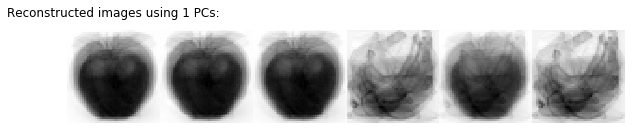

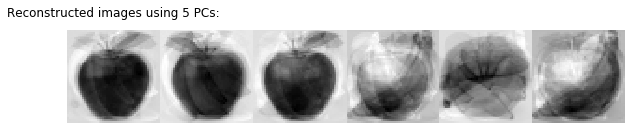

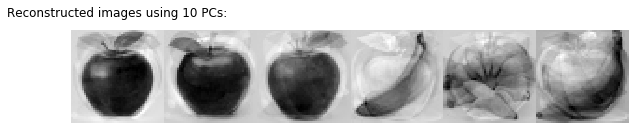

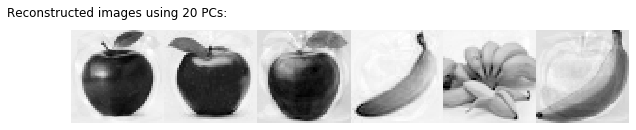

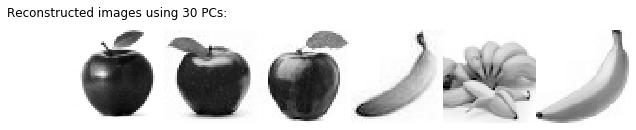

In [61]:
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings("ignore")

## Input:
#  Z: Dataset
#  n: number of dimensions
#  m_pics: number of pics per class (Apple, Banana). Min 1, Max 15
def plot_reconstruct(Z, W_pca, n, m_pics=3):

    # Center Z
    Z_centered = Z - np.mean(Z, axis=0)
    # x=w*z
    X_pca = np.matmul(W_pca[:n,:], Z_centered[:,:,None])
    # x_reversed=r*x
    Z_hat = np.matmul(W_pca[:n,:].T, X_pca)[:,:,0] + np.mean(Z, axis=0)
    
    # Setup figure size that scales with number of images
    fig = plt.figure(figsize = (10,10))
    
    # Setup a (n_pics,2) grid of plots (images)
    gs = gridspec.GridSpec(1, 2*m_pics)
    gs.update(wspace=0.0, hspace=0.0)
    for i in range(m_pics):
        for j in range(0,2):
            # Add a new subplot
            ax = plt.subplot(gs[0, i+j*m_pics])
            # Insert image data into the subplot
            ax.imshow(np.reshape(Z_hat[i+(15*j)], (50,50)), cmap='gray', interpolation='nearest')
            # Remove x- and y-axis from each plot
            ax.set_axis_off()
    
    plt.subplot(gs[0,0]).set_title("Reconstructed images using %d PCs:"%(n), size='large', y=1.08)
    plt.show()
    
pca = PCA(n_components=m) # create the object
pca.fit(Z)    # compute optimal transform W_PCA
W_pca = pca.components_
    
# The values of PCS n to plot for. You can change these to experiment
num_com = [1, 5, 10, 20, 30]
for n in num_com:
    # If you want to print different amount of pictures, you can change the value of m_pics. (1-15)
    plot_reconstruct(Z, W_pca, n, m_pics=3)

Observing the reconstructed images, one can clearly see that the reconstructions improve with an increasing number of principal components. This is in line with the decreasing reconstruction error seen in the previous student task.

<a id='reconstructionerror'></a>
<div class=" alert alert-info">
    <b>Demo.</b> Principal Directions. <br/> 
    
It is instructive to examine the rows $\mathbf{u}^{(1)},\mathbf{u}^{(2)}...,\mathbf{u}^{(n)}$ of the optimal compression matrix $\mathbf{W}_{\rm PCA}$. These rows capture the most relevant information contained in the fruit image vectors $\mathbf{z}^{(i)}$. These rows, which are the eigenvectors of the sample covariance matrix $\mathbf{Q}$, are sometimes called "principal directions". The code snippet below plots the five first principal directions.
</div>

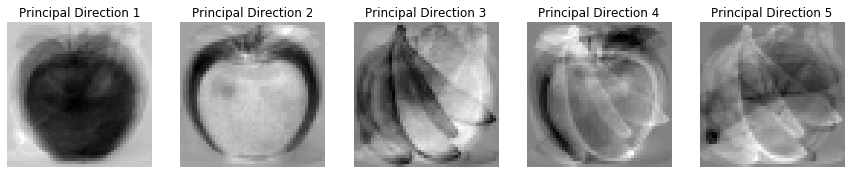

In [62]:
def plot_princ_comp(W_pca):
    fig, ax = plt.subplots(1, 5, figsize=(15,15))
    # Select the PCs we are plotting
    # You can change these to see what other components look like
    plot_pd = [0,1,2,3,4]

    for i in range(len(plot_pd)):
        ax[i].imshow(np.reshape(W_pca[plot_pd[i]] * 255, (50,50)), cmap='gray')
        ax[i].set_title("Principal Direction %d"%(plot_pd[i] + 1))
        ax[i].set_axis_off()  # Remove x- and y-axis from each image
    plt.show()

plot_princ_comp(W_pca)

## PCA for Data Visualization
<a id="Q3"></a>

An important application of PCA is data visualization. By using PCA to reduce the dimensionality of higher dimensional data to two or three dimensions, it is possible to visualize high dimensional data along those directions in which the data exhibits the largest variance. 

For example, when using PCA with $n=2$ PCs, the resulting feature vectors $\mathbf{x}^{(1)} = W_{\rm PCA} \mathbf{z}_c^{(1)}, \ldots, \mathbf{x}^{(m)} = W_{\rm PCA} \mathbf{z}_c^{(m)} \in \mathbb{R}^{2}$ can be visualized as a two-dimensional scatterplot whose x-axis represents the first PC $x_{1}^{(i)}$ and y-axis the second PC $x_{2}^{(i)}$.

<a id='dataprojection'></a>
<div class=" alert alert-warning">
    <b>Student Task.</b> PCA with $n=2$.   <br/> 
    
The fruit images are represented by long vectors $\mathbf{z}^{(i)}$ of length $D=2500$. In order to represent these images in a scatter plot we can PCA with $n=2$ which results in feature vectors $\mathbf{x}^{(i)} = \mathbf{W}_{\rm PCA} \mathbf{z}_c^{(i)}$ of length $2$ which can be depicted in a scatter plot. Compute these feature vectors and store them in the numpy array `X_visual` of shape (m,2).

</div>

In [68]:
X_visual = np.zeros((m,2))

pca = PCA(n_components=2)    
pca.fit(Z)    # Fit pca object on data
W_pca = pca.components_
X_visual = pca.transform(Z)    # Perform pca transform on data


### STUDENT TASK ### 
# YOUR CODE HERE
#raise NotImplementedError()

In [69]:
# Perform some sanity checks on the result
assert X_visual.shape == (m, 2), "shape of X_visual is not correct."


print('Sanity checks passed!')

Sanity checks passed!


<a id='dataprojection'></a>
<div class=" alert alert-info">
    <b>Demo.</b> Scatter Plots using Two PCs.   <br/> 

The following code visualizes the data as a scatter plot using either the first two PCs $x_{1}$, $x_{2}$ or using the 8th and 9th PCs $x_{8}$ and $x_{9}$. As we learned, using the first two PCs $x_{1}$ and $x_{2}$ as features results in a smaller reconstruction error compared to using PCs $x_{8}$, $x_{9}$. As expected, $x_{1}$ and $x_{2}$ contain more relevant information about the content of the images.

</div>

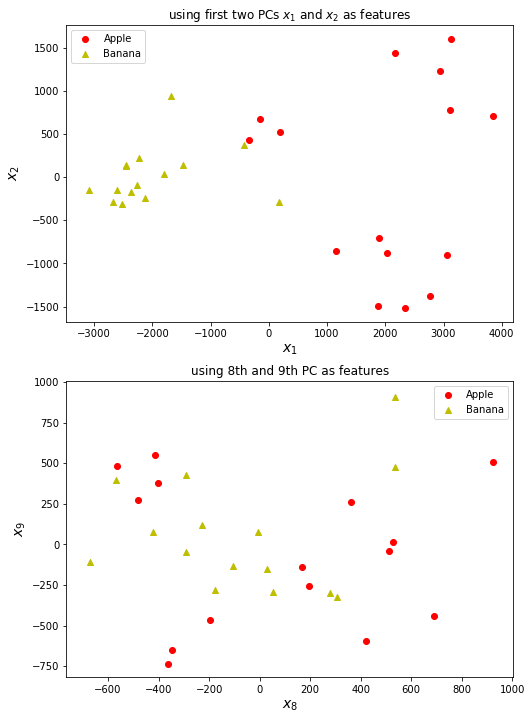

In [70]:
# Fit PCA with m components
pca = PCA(n_components=m)
pca.fit(Z)

# Retrieve the optimal compression matrix and calculate the compressed matrix X
W_pca = pca.components_
X = pca.transform(Z)
 
X_PC12 = X[:,[0,1]]  # Choose the principle components 1 and 2
X_PC89 = X[:,[7,8]]  # Choose principle components 7 and 8

plt.rc('axes', labelsize=14)    # Set fontsize of the x and y labels
 
fig, ax = plt.subplots(2, 1, figsize=(8,12))  # Create two subplots

# Scatterplot of the compressed data w.r.t PCs 1 and 2
ax[0].scatter(X_PC12[:15,0], X_PC12[:15,1], c='r',marker='o', label='Apple')
ax[0].scatter(X_PC12[15:,0], X_PC12[15:,1], c='y', marker='^', label='Banana')
ax[0].set_title('using first two PCs $x_{1}$ and $x_{2}$ as features')
ax[0].legend()
ax[0].set_xlabel('$x_{1}$')
ax[0].set_ylabel('$x_{2}$')
    
# Scatterplot of the compressed data w.r.t PCs 7 and 8
ax[1].scatter(X_PC89[:15,0], X_PC89[:15,1], c='r', marker='o', label='Apple')
ax[1].set_title('using 8th and 9th PC as features')
ax[1].scatter(X_PC89[15:,0], X_PC89[15:,1], c='y', marker='^', label='Banana')
ax[1].legend()
ax[1].set_xlabel('$x_{8}$')
ax[1].set_ylabel('$x_{9}$')

plt.show()

## Using Linear regression with PCA for House Price Prediction 

<a id="Q2"></a>

We now show how PCA can be used as a pre-processing step for another ML method, such as linear regression. To this end, we consider an example problem in which our task is to predict the house prices $\mathbf{y}$ based on some features $x_1,\ldots, x_n$.

### The Data

Our goal is to learn a good predictor $h(\mathbf{x})$ for the price $y$ of a house. The prediction $h(\mathbf{x})$ is based on several features (characteristics) $\mathbf{x} = \big(x_{1},\ldots,x_{n}\big)^{T}$ such as the average number of rooms per dwelling $x_{1}$ or the nitric oxides concentration $x_{2}$ near the house. 

To learn a good predictor $h(\mathbf{x})$, we use historic recordings of house sales. These recordings consist of $m$ data points. Each data point is characterized by the house features $\mathbf{x}^{(i)} \in \mathbb{R}^{n}$ and the selling price $y^{(i)}$. ML methods find or learn a good predictor $h(\mathbf{x})$ by minimizing the average error $h(\mathbf{x}^{(i)}) - y^{(i)}$ for $i=1,\ldots,m$.

<a id='handsondata'></a>
<div class=" alert alert-info">
<p><b>Demo.</b> Loading the Data.</p>
    
The following code snippet defines a function `Z,y= GetFeaturesLabels(m,D)` which reads in data of previous house sales. The input parameters are the number `m` of data points and the number `D` of features to be used for each data point. The function returns a matrix $\mathbf{Z}$ and vector $\mathbf{y}$. 

The features $\mathbf{z}^{(i)}$ of the sold houses are stored in the rows of the numpy array `Z` (of shape (m,D)) and the corresponding selling prices $y^{(i)}$ in the numpy array `y` (shape (m,1)). The two arrays represent the feature matrix $\mathbf{Z} = \begin{pmatrix} \mathbf{z}^{(1)} & \ldots & \mathbf{z}^{(m)} \end{pmatrix}^{T}$ and the label vector $\mathbf{y} = \big( y^{(1)}, \ldots, y^{(m)} \big)^{T}$. 

</div>

In [71]:
# import "Pandas" library/package (and use shorthand "pd" for the package) 
# Pandas provides functions for loading (storing) data from (to) files
import pandas as pd  
from matplotlib import pyplot as plt 
from IPython.display import display, HTML
import numpy as np   
import random
from sklearn.preprocessing import StandardScaler

def GetFeaturesLabels(m=10, D=10):
    house_dataset = load_boston()
    house = pd.DataFrame(house_dataset.data, columns=house_dataset.feature_names) 
    x1 = house['TAX'].values.reshape(-1,1)   # vector whose entries are the tax rates of the sold houses
    x2 = house['AGE'].values.reshape(-1,1)   # vector whose entries are the ages of the sold houses
    x1 = x1[0:m]
    x2 = x2[0:m]
    np.random.seed(43)
    Z = np.hstack((x1,x2,np.random.randn(m,D))) 
    
    Z = Z[:,0:D] 

    y = house_dataset.target.reshape(-1,1)  # create a vector whose entries are the labels for each sold house
    y = y[0:m]
    
    return Z, y

<a id='pcaandlinreg'></a>
<div class=" alert alert-warning">
    <p><b>Student Task.</b> PCA with Linear Regression. <br/> </p>

The code snippet below reads in $m=500$ data points representing house sales. Each house sale is represented by a long feature vector $\mathbf{z}^{(i)}\in \mathbb{R}^{D}$ of length $D=10$. The features $\mathbf{z}^{(i)}$ of the first $480$ data points are used to compute a compression matrix $\mathbf{W}_{\rm PCA}$ using PCA. The compression matrix is then applied to the feature vectors of the last $20$ data points to obtain a labeled data set $\mathbb{X}$ with features $\mathbf{x}^{(i)} = \mathbf{W}_{\rm PCA} \mathbf{z}_c^{(i)}$ and labels $y^{(i)}$ for $i=481,\ldots,500$.

The dataset $\mathbb{X}$ is split into a training set, whose features are stored in the numpy array `Z_train` and labels in numpy array `y_train`, and a validation set, stored in the numpy arrays `Z_val` and `y_val`. Combine PCA with linear regression using different number $n$ of PCs. For each choice $n=1,\ldots,D$, compute transformed feature vectors for training and validation set. Then train a linear regression model using `LinearRegression.fit()` and compute the resulting training and validation error. Store the resulting training and validation errors in the numpy arrays `err_train` and `err_val` of shape (D, ).

When initializating `LinearRegression` please use `LinearRegression(fit_intercept=True)`

</div>

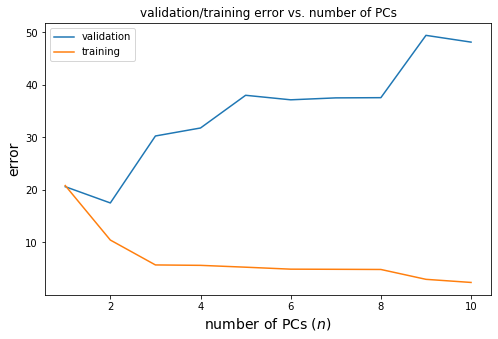

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston

m1 = 500   # total number of data points 
D = 10    # length of raw feature vector 

Z_temp, y = GetFeaturesLabels(m1, D)   # read in m data points from the house sales database 
        
# Use these features for PCA 
Z_pca = Z_temp[:480,:]  # read out feature vectors of first 480 data points 

# Use these features and labels for linear regression (with transformed features)
Z_temp = Z_temp[480:,:]    # Read out feature vectors of last 20 data points 
y = y[480:,:]    # Read out labels of last 20 data points 

# Datasets which will be preprocessed and used with linear regression
Z_train, Z_val, y_train, y_val = train_test_split(Z_temp, y, test_size=0.2, random_state=42)

err_train = np.zeros(D)    # Array for storing training errors of the linear regression model
err_val = np.zeros(D)     # Array for storing validation errors of the linear regression model

for n in range(1, D+1):
    
    # Create the PCA object and fit
    pca = PCA(n_components=n)
    pca.fit(Z_pca)
    
    # transform long feature vectors (length D) to short ones (length n)
    X_train = pca.transform(Z_train)
    X_val   = pca.transform(Z_val)
    ### STUDENT TASK ### 
    #  use X_train,y_train to train linear regression model 
    reg = LinearRegression(fit_intercept=True)  
    reg = reg.fit(X_train, y_train)
    #  use resulting model to predict labels for training and validation data w
    
    #  store the predicted labels on training set in numpy array y_pred_train and 
    y_pred_train=reg.predict(X_train)
    #  predicted labels on validation set in numpy array y_pred_val
    y_pred_val=reg.predict(X_val)
    # YOUR CODE HERE
    #raise NotImplementedError()
    err_train[n-1] = np.mean((y_train - y_pred_train)**2)  # compute training error 
    err_val[n-1] = np.mean((y_val - y_pred_val)**2)   # compute validation error 

# Plot the training and validation errors
plt.figure(figsize=(8,5))
plt.plot(range(1, D+1), err_val, label="validation")
plt.plot(range(1, D+1), err_train, label="training")
plt.xlabel('number of PCs ($n$)')
plt.ylabel(r'error')
plt.legend()
plt.title('validation/training error vs. number of PCs')
plt.show()

In [73]:
# Perform sanity checks on the outputs
assert err_train[0] >= err_train[4], "values in err_train wrong"
assert err_val[1] <= err_val[4], "values in err_val wrong"


print('Sanity checks passed!')

Sanity checks passed!


If the task is correctly solved, one should see that while the training error decreases monotonically with an increasing number of components, the validation error does not. Rather, there is an optimum number of components to be used. This is similar to what was observed in round 4, where we searched for the optimum number of features to be used for predicting the grayscale values of pixels. The difference is that in the task above we use PCA for each $n$ to obtain the $n$ features that capture as much of the variance of the original data as possible (for $n$ features).

## The Final Quiz

<a id='QuestionR6_1'></a>
<div class=" alert alert-warning">
    <p><b>Student Task.</b> Question R6.1. </p>

 <p>Which of the following statements is true?</p>

<ol>
  <li> Dimensionality reduction helps to avoid overfitting.</li>
  <li> Dimensionality reduction can only be used for labeled data points.</li>
  <li> Dimensionality reduction can only be used for vectors having no more than $100$ entries.</li>
  <li> Dimensionality reduction is a classification method.</li>
</ol> 

</div>

In [ ]:
answer_R6_Q1  = 1
# YOUR CODE HERE
# raise NotImplementedError()

In [ ]:
# this cell is for tests
assert answer_R6_Q1 in [1,2,3,4], '"answer_R6_Q1" Value should be an integer between 1 and 4.'
print('Sanity check tests passed!')


<a id='QuestionR6_2'></a>
<div class=" alert alert-warning">
    <p><b>Student Task.</b> Question R6.2. </p>

 <p>Which of the following statements is true?</p>

<ol>
  <li> In general, dimensionality reduction increases the computational requirements of fitting a model on the data.</li>
  <li> No information in the original data is lost when performing dimensionality reduction via PCA.</li>
  <li> In general, dimensionality reduction reduces the computational requirements of fitting a model on the data.</li>
  <li> PCA cannot be used for data visualization.</li>
</ol> 

</div>

In [75]:
answer_R6_Q2  = 3
# YOUR CODE HERE
#raise NotImplementedError()

In [76]:
# this cell is for tests
assert answer_R6_Q2 in [1,2,3,4], '"answer_R6_Q2" Value should be an integer between 1 and 2.'
print('Sanity check tests passed!')


Sanity check tests passed!


<a id='QuestionR6_3'></a>
<div class=" alert alert-warning">
    <p><b>Student Task.</b> Question R6.3. </p>

 <p>Consider using PCA as preprocessing to transform long raw feature vectors $\mathbf{z} \in \mathbb{R}^{D}$ to  shorter feature vectors $\mathbf{x} \in \mathbb{R}^{n}$ that are then used in linear regression. What is the effect of using a larger number $n$ of principal components in PCA?</p>

<ol>
  <li> The training error obtained from linear regression will decrease.</li>
  <li> The training error obtained from linear regression will increase.</li>
</ol> 

</div>

In [77]:
answer_R6_Q3  = 1
# YOUR CODE HERE
#raise NotImplementedError()

In [78]:
# this cell is for tests
assert answer_R6_Q3 in [1,2], '"answer_R6_Q3" Value should be an integer between 1 and 2.'
print('Sanity check tests passed!')


Sanity check tests passed!
